In [ ]:
# Updated imports for latest versions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

# TensorFlow/Keras for LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Transformers for BERT
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Now you can read the CSV from your Drive path
df = pd.read_csv('/content/drive/MyDrive/combined_dataset_new.csv', encoding='utf8')


Mounted at /content/drive


In [ ]:
df

,id,comment,label
0,1,The weather is nice today.,0
1,2,I need to buy some groceries.,0
2,3,What time does the store open?,0
3,4,She is reading a book.,0
4,5,The train arrives at 5 PM.,0
...,...,...,...
22356,1000,பாட்டோட வரிகள் எல்லாமே ஒரு மயிரு மாதிரி அர்த்த...,2
22357,1001,இந்த புண்ட படத்தை பார்க்குறதுக்கு பதிலா வேற எத...,2
22358,1002,இந்த சுன்னி சும்மாவே இருக்க மாட்டான் லூசு பய,2
22359,1003,சுன்னி,2


In [ ]:
# Text cleaning functions
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = ''.join([c for c in text if not c.isnumeric()])
    return text.strip()

In [ ]:
df

,id,comment,label
0,1,The weather is nice today.,0
1,2,I need to buy some groceries.,0
2,3,What time does the store open?,0
3,4,She is reading a book.,0
4,5,The train arrives at 5 PM.,0
...,...,...,...
22356,1000,பாட்டோட வரிகள் எல்லாமே ஒரு மயிரு மாதிரி அர்த்த...,2
22357,1001,இந்த புண்ட படத்தை பார்க்குறதுக்கு பதிலா வேற எத...,2
22358,1002,இந்த சுன்னி சும்மாவே இருக்க மாட்டான் லூசு பய,2
22359,1003,சுன்னி,2


In [ ]:
df.columns


Index(['id', 'comment', 'label'], dtype='object')

In [ ]:
df.head()



,id,comment,label
0,1,The weather is nice today.,0
1,2,I need to buy some groceries.,0
2,3,What time does the store open?,0
3,4,She is reading a book.,0
4,5,The train arrives at 5 PM.,0


In [ ]:
#calculate length of the comment
df['length'] = df['comment'].apply(len)
df.head()

,id,comment,label,length
0,1,The weather is nice today.,0,26
1,2,I need to buy some groceries.,0,29
2,3,What time does the store open?,0,30
3,4,She is reading a book.,0,22
4,5,The train arrives at 5 PM.,0,26


In [ ]:
exclude = set(",.:;'\"-?!/´`%")
def removePunctuation(txt):
    return ''.join([(c if c not in exclude else " ") for c in txt])

def removeNumbers(txt):
    return ''.join(c for c in txt if not c.isnumeric())


In [ ]:
df['cleaned'] = df['comment'].apply(lambda x: removePunctuation(x))
df.head()

,id,comment,label,length,cleaned
0,1,The weather is nice today.,0,26,The weather is nice today
1,2,I need to buy some groceries.,0,29,I need to buy some groceries
2,3,What time does the store open?,0,30,What time does the store open
3,4,She is reading a book.,0,22,She is reading a book
4,5,The train arrives at 5 PM.,0,26,The train arrives at 5 PM


In [ ]:
df


,id,comment,label,length,cleaned
0,1,The weather is nice today.,0,26,The weather is nice today
1,2,I need to buy some groceries.,0,29,I need to buy some groceries
2,3,What time does the store open?,0,30,What time does the store open
3,4,She is reading a book.,0,22,She is reading a book
4,5,The train arrives at 5 PM.,0,26,The train arrives at 5 PM
...,...,...,...,...,...
22356,1000,பாட்டோட வரிகள் எல்லாமே ஒரு மயிரு மாதிரி அர்த்த...,2,81,பாட்டோட வரிகள் எல்லாமே ஒரு மயிரு மாதிரி அர்த்த...
22357,1001,இந்த புண்ட படத்தை பார்க்குறதுக்கு பதிலா வேற எத...,2,73,இந்த புண்ட படத்தை பார்க்குறதுக்கு பதிலா வேற எத...
22358,1002,இந்த சுன்னி சும்மாவே இருக்க மாட்டான் லூசு பய,2,44,இந்த சுன்னி சும்மாவே இருக்க மாட்டான் லூசு பய
22359,1003,சுன்னி,2,6,சுன்னி


In [ ]:
df['cleaned'] = df['cleaned'].apply(lambda x: removeNumbers(x))
df.head()

,id,comment,label,length,cleaned
0,1,The weather is nice today.,0,26,The weather is nice today
1,2,I need to buy some groceries.,0,29,I need to buy some groceries
2,3,What time does the store open?,0,30,What time does the store open
3,4,She is reading a book.,0,22,She is reading a book
4,5,The train arrives at 5 PM.,0,26,The train arrives at PM


In [ ]:
from collections import Counter

plt.rc('font', family='Lohit Devanagari')

results = Counter()
df.cleaned.str.split().apply(results.update)

most = results.most_common()
print(most[:10])

[('you', 4009), ('I', 4000), ('You', 3500), ('the', 3254), ('a', 3251), ('to', 2504), ('are', 2253), ('is', 2006), ('and', 1756), ('The', 1750)]


In [ ]:
words = [word for i in df[df['label'] == 1]['cleaned'].str.split() for word in i]

counter = Counter(words)
most = counter.most_common(20)

most

[('இந்த', 28),
 ('இருந்தது', 26),
 ('இன்று', 22),
 ('புதிய', 15),
 ('இருக்கு', 15),
 ('ஒரு', 13),
 ('காலை', 11),
 ('மணிக்கு', 10),
 ('ஆனால்', 10),
 ('இல்லை', 10),
 ('ஆனா', 10),
 ('நான்', 9),
 ('சற்று', 9),
 ('சில', 9),
 ('வேலை', 8),
 ('நேரம்', 8),
 ('செய்தேன்', 8),
 ('தான்', 8),
 ('இன்னும்', 8),
 ('வாங்கினேன்', 7)]

In [ ]:
df.groupby(['label'])['label'].describe()[['count']]

,count
label,
0,13382.0
1,175.0
2,8804.0


In [ ]:
# Assuming df contains your cleaned dataset (e.g., 'text' and 'label' columns)
df_cleaned = df[['cleaned', 'label']]  # Or any other columns you want to save

# Save to a new CSV file
df_cleaned.to_csv('cleaned_dataset.csv', index=False)


In [ ]:
df_cleaned.head()

,cleaned,label
0,The weather is nice today,0
1,I need to buy some groceries,0
2,What time does the store open,0
3,She is reading a book,0
4,The train arrives at PM,0


In [ ]:
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import pandas as pd # Ensure pandas is imported if not already

# Step 0: Ensure labels are numeric and in range [0, 2]
# Example: if your labels are strings like ['positive', 'neutral', 'negative'], map them to integers
label_mapping = {'positive': 0, 'neutral': 1, 'negative': 2}


# Map labels if needed
if isinstance(df_cleaned['label'].iloc[0], str):
    # Use .loc for assignment to avoid SettingWithCopyWarning
    df_cleaned.loc[:, 'label'] = df_cleaned['label'].map(label_mapping)

# Convert labels to int (if not already)
# This line seems redundant after the split and explicit list conversion below,
# but keeping it doesn't hurt and ensures the DataFrame column itself is int.
df_cleaned.loc[:, 'label'] = df_cleaned['label'].astype(int)

# Verify labels are in the correct range
# This assert is good, but we'll add a more explicit check later
# assert df_cleaned['label'].min() >= 0 and df_cleaned['label'].max() < 3, \
#     "Labels must be integers in the range [0, 2] for num_labels=3"

# Step 1: Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_cleaned['cleaned'].tolist(),
    df_cleaned['label'].tolist(),
    test_size=0.2,
    random_state=42
)

#  Explicitly convert labels to standard Python integers AFTER the split
train_labels = [int(label) for label in train_labels]
val_labels = [int(label) for label in val_labels]


#  Add a check for valid labels BEFORE creating the dataset
allowed_labels = {0, 1, 2}
if not set(train_labels).issubset(allowed_labels):
    invalid_train_labels = set(train_labels) - allowed_labels
    raise ValueError(f"Invalid labels found in training data: {invalid_train_labels}. Labels must be in {allowed_labels}.")

if not set(val_labels).issubset(allowed_labels):
    invalid_val_labels = set(val_labels) - allowed_labels
    raise ValueError(f"Invalid labels found in validation data: {invalid_labels}. Labels must be in {allowed_labels}.")


# Step 2: Use the XLM-RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

# Tokenize with truncation and padding
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Step 3: Dataset class
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Ensure labels are converted to LongTensor as expected by PyTorch loss functions
        # This is already good, but the explicit list conversion above adds robustness.
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Step 4: Create dataset instances
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

#  Step 5: Load XLM-RoBERta model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=3)

# Optional: For debugging, run on CPU to isolate CUDA errors
# Uncomment the following line if you want to force CPU usage:
# model.to('cpu')

# Step 6: Define training arguments (without `evaluation_strategy` and `save_strategy`)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    do_eval=True,
    do_train=True,
)

# Step 7: Setup Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Step 8: Train the model
trainer.train()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
10,1.013200
20,1.001800
30,1.015800
40,0.992800
50,0.996300
60,0.963900
70,0.953300
80,0.924800
90,0.873600
100,0.822300


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/l

TrainOutput(global_step=5590, training_loss=0.13302507268274052, metrics={'train_runtime': 3319.4419, 'train_samples_per_second': 26.944, 'train_steps_per_second': 1.684, 'total_flos': 5883216020398080.0, 'train_loss': 0.13302507268274052, 'epoch': 5.0})

In [ ]:
trainer.evaluate()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 0.183556467294693,
 'eval_runtime': 26.7306,
 'eval_samples_per_second': 167.336,
 'eval_steps_per_second': 10.475,
 'epoch': 5.0}

In [ ]:
# Evaluate on validation set
predictions = trainer.predict(val_dataset)

# Get predicted class labels
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = val_labels


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'  # or Arial, Times New Roman, etc.


Accuracy: 0.9682539682539683
F1 Score (macro): 0.9144232211301481

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.97      0.98      0.97      2701
    Positive       0.81      0.81      0.81        26
    Negative       0.96      0.96      0.96      1746

    accuracy                           0.97      4473
   macro avg       0.91      0.91      0.91      4473
weighted avg       0.97      0.97      0.97      4473



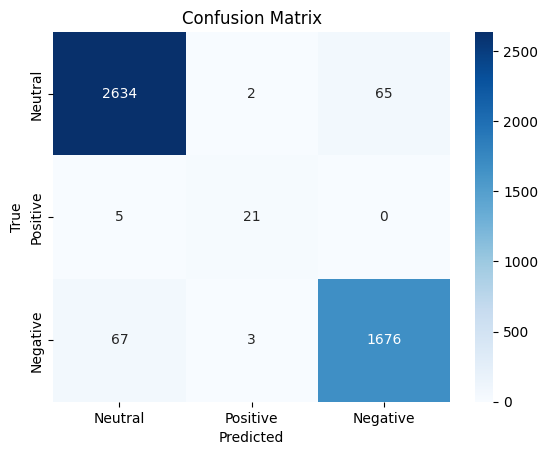

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# F1 Score (macro = all classes equally weighted)
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Neutral", "Positive", "Negative"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neutral", "Positive", "Negative"], yticklabels=["Neutral", "Positive", "Negative"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example new sentence
new_text = ["තමාට පදිංචිව සිටිමට අයිතිවාසිකම් නොමැත ."]

# Tokenize the input and move to the correct device
inputs = tokenizer(new_text, return_tensors='pt', padding=True, truncation=True, max_length=128)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Put model in eval mode
model.eval()

# Get prediction
with torch.no_grad():
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=-1)

# Map prediction to label
label_map = {0: "Neutral", 1: "Positive", 2: "Negative"}
print(f'Predicted label: {prediction.item()} → {label_map[prediction.item()]}')


Predicted label: 0 → Neutral


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
model.save_pretrained('./fine_tuned_bert',safe_serialization=True)
tokenizer.save_pretrained('./fine_tuned_bert')


('./fine_tuned_bert/tokenizer_config.json',
 './fine_tuned_bert/special_tokens_map.json',
 './fine_tuned_bert/sentencepiece.bpe.model',
 './fine_tuned_bert/added_tokens.json',
 './fine_tuned_bert/tokenizer.json')

In [ ]:
import shutil

shutil.make_archive('fine_tuned_bert', 'zip', './fine_tuned_bert')


'/content/fine_tuned_bert.zip'

In [ ]:
from google.colab import files
files.download('fine_tuned_bert.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import re

def clean_sinhala(text):
    text = re.sub(r'[^\u0D80-\u0DFF\s]', '', text)  # Sinhala Unicode range
    return text

df_cleaned['cleaned'] = df_cleaned['cleaned'].apply(clean_sinhala)


/tmp/ipython-input-3030707012.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cleaned'] = df_cleaned['cleaned'].apply(clean_sinhala)


In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

sinhala_sentence = "මෙය ව්‍යාජ ප්‍රචාරයකි"
prediction = classifier(sinhala_sentence)
print(prediction)


Device set to use cuda:0


[{'label': 'LABEL_0', 'score': 0.999957799911499}]
